In [1]:
import os
os.environ["SQLALCHEMY_SILENCE_UBER_WARNING"]="1"

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
Base = automap_base()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Mike\AppData\Local\Temp\ipykernel_16228\804714559.py:5: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(engine, reflect=True)
C:\Users\Mike\AppData\Local\Temp\ipykernel_16228\804714559.py:5: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.station, and will be replaced in the string-lookup table.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
last_date = session.query(func.max(measurement.date)).scalar()

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date()

one_year_ago = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query = (session.query(measurement.date, measurement.prcp)
         .filter(measurement.date >= str(one_year_ago))
         .order_by(desc(measurement.date)))

data = [row for row in query]

# Save the query results as a Pandas DataFrame. Explicitly set the column names
columns = ['date', 'precipitation']
df = pd.DataFrame(data, columns=columns)

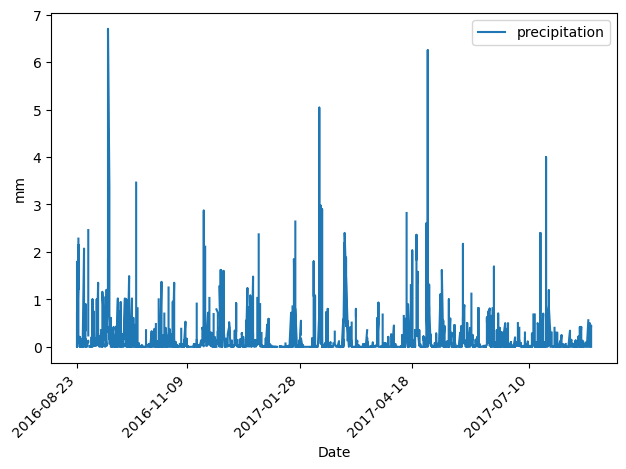

In [12]:
#  Sort the dataframe by date
df = df.sort_values('date')

df['date'] = pd.to_datetime(
    df['date'],
    errors='coerce',
)
df = df.set_index('date')
#  Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(xlabel='Date', ylabel='mm')

# Rotate the x tick labels for better readability
plt.tick_params(axis='x', labelrotation=45)

#  Set the custom x-axis tick positions
custom_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
ax.set_xticks(custom_dates)

#  Use DateFormatter to format the custom tick labels
date_format = "%Y-%m-%d"
ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
plt.legend(loc='upper right')

#  Show the plot
plt.tight_layout()
plt.savefig("images/fig1.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session
 .query(measurement.station, func.count(measurement.station).label('count'))
 .group_by(measurement.station)
 .order_by(desc('count'))
 .all())

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
(session.query(func.min(measurement.tobs).label('min'),
              func.max(measurement.tobs).label('max'),
              func.avg(measurement.tobs).label('average'))
              .filter(measurement.station == most_active_stations[0][0])).all()

[(54.0, 85.0, 71.66378066378067)]

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_last_date = (session.query(func.max(measurement.date))
 .filter(measurement.station == most_active_stations[0][0])
 .scalar())

# Convert station_last_date to a datetime object
station_last_date = dt.datetime.strptime(station_last_date, '%Y-%m-%d').date()

# Calculate one year prior
year_prior = station_last_date - dt.timedelta(days=365)


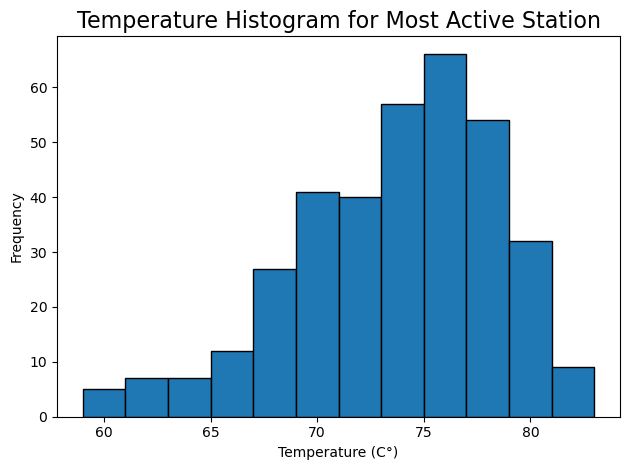

In [18]:
query_2= (session.query(measurement.tobs)
         .filter(measurement.station == most_active_stations[0][0])
         .filter(measurement.date >= str(year_prior))
         ).all()
temperatures = [temp[0] for temp in query_2]

# Create the histogram with 12 bins
plt.hist(temperatures, bins=12, edgecolor='black')

# Labeling the plot
plt.xlabel('Temperature (C°)')
plt.ylabel('Frequency')
plt.title('Temperature Histogram for Most Active Station', fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig("images/fig2.png")
plt.show()

# Close Session

In [19]:
# Close Session
session.close()